In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import os
import warnings

warnings.filterwarnings('ignore')
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"
%matplotlib inline

In [2]:
# Load the dataset
drgcodes = pd.read_csv('DRGCODES.csv.gz')

# Preview the dataset
drgcodes.head()


,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,342,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,344,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,345,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,346,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN


In [3]:
# Step 3: Check for nulls and duplicates
drgcodes.info()
print(drgcodes.isnull().sum())
drgcodes.drop_duplicates(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125557 entries, 0 to 125556
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ROW_ID         125557 non-null  int64  
 1   SUBJECT_ID     125557 non-null  int64  
 2   HADM_ID        125557 non-null  int64  
 3   DRG_TYPE       125557 non-null  object 
 4   DRG_CODE       125557 non-null  int64  
 5   DESCRIPTION    125494 non-null  object 
 6   DRG_SEVERITY   66634 non-null   float64
 7   DRG_MORTALITY  66634 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.7+ MB
ROW_ID               0
SUBJECT_ID           0
HADM_ID              0
DRG_TYPE             0
DRG_CODE             0
DESCRIPTION         63
DRG_SEVERITY     58923
DRG_MORTALITY    58923
dtype: int64


In [4]:
#  Encode categorical features
drgcodes['DRG_TYPE_CAT'] = drgcodes['DRG_TYPE'].astype('category').cat.codes
drgcodes['DESCRIPTION_CAT'] = drgcodes['DESCRIPTION'].astype('category').cat.codes


In [5]:
!pip install sdv



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
#  Save cleaned dataset
drg_cleaned = drgcodes.copy()
drg_cleaned.to_csv("drgcodes_cleaned.csv", index=False)



In [ ]:
#  Generate metadata for SINGLE TABLE
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(drg_cleaned)

#  Initialize synthesizer (no enforce_minimal in this version)
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=30
)

#  Fit the synthesizer to the data
synthesizer.fit(drg_cleaned)

#  Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)

#  Save synthetic data
synthetic_data.to_csv("synthetic_drgcodes.csv", index=False)

#  Preview
synthetic_data.head()

PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
DRG_TYPE               3
DRG_CODE               11
DESCRIPTION            1368
DRG_SEVERITY           6
DRG_MORTALITY          6
DRG_TYPE_CAT           3
DESCRIPTION_CAT        11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)


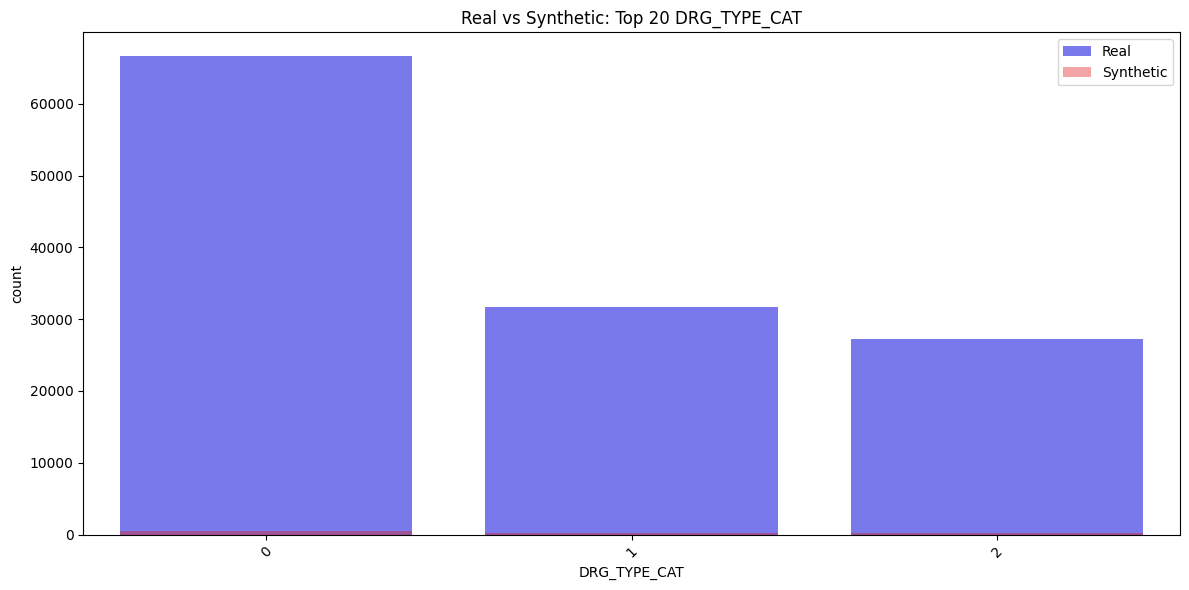

In [9]:
# Plot top 20 most frequent ICD9_CODE_CAT values
top_n = 20
top_categories = drg_cleaned['DRG_TYPE_CAT'].value_counts().nlargest(top_n).index

# Filter both datasets
filtered_real = drg_cleaned[drg_cleaned['DRG_TYPE_CAT'].isin(top_categories)]
filtered_syn = synthetic_data[synthetic_data['DRG_TYPE_CAT'].isin(top_categories)]

plt.figure(figsize=(12, 6))
sns.countplot(x='DRG_TYPE_CAT', data=filtered_real, color='blue', label='Real', alpha=0.6)
sns.countplot(x='DRG_TYPE_CAT', data=filtered_syn, color='red', label='Synthetic', alpha=0.4)
plt.legend()
plt.title("Real vs Synthetic: Top 20 DRG_TYPE_CAT")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [10]:
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata

#  Droping high-cardinality and unneeded columns
columns_to_drop = ['DESCRIPTION', 'HADM_ID', 'SUBJECT_ID', 'DESCRIPTION_CAT', 'HADM_ID_scaled']
drg_sample_reduced = drg_cleaned.drop(columns=[col for col in columns_to_drop if col in drg_cleaned.columns])

#  Encode categorical columns
cat_cols = ['DRG_TYPE', 'DRG_CODE', 'DRG_SEVERITY', 'DRG_MORTALITY']
for col in cat_cols:
    if col in drg_sample_reduced.columns:
        drg_sample_reduced[col] = drg_sample_reduced[col].astype('category').cat.codes

#  Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(drg_sample_reduced)

#  Train TVAE synthesizer
vae_synthesizer = TVAESynthesizer(metadata=metadata, epochs=30)
vae_synthesizer.fit(drg_sample_reduced)

#  Sample and save synthetic data
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)
synthetic_data_vae.to_csv("synthetic_drg_data_vae.csv", index=False)
print("VAE synthetic data generated and saved as 'synthetic_drg_data_vae.csv'")



VAE synthetic data generated and saved as 'synthetic_drg_data_vae.csv'


In [11]:
#  Save cleaned dataset
drg_cleaned = drgcodes.copy()
drg_cleaned.to_csv("drgcodes_cleaned.csv", index=False)

In [12]:
#  Save cleaned dataset
drg_cleaned = drgcodes.copy()
drg_cleaned.to_csv("drgcodes_cleaned.csv", index=False)

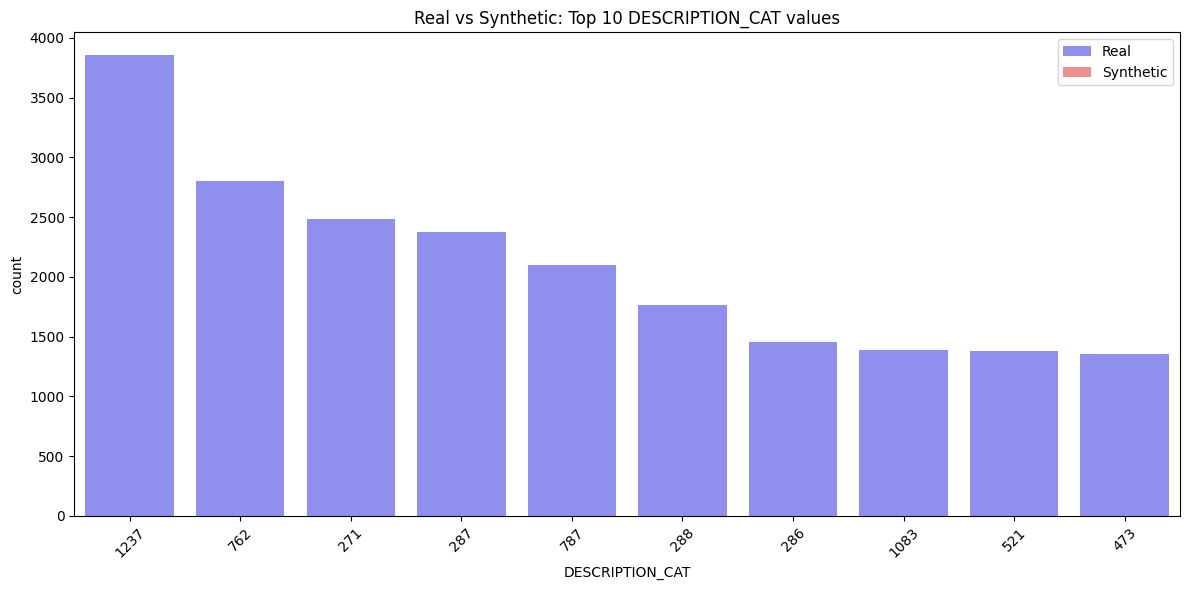

In [13]:
features = ['DRG_CODE', 'DESCRIPTION_CAT']
drg_cleaned['target'] = (drg_cleaned['DRG_CODE'] > drg_cleaned['DRG_CODE'].median()).astype(int)
synthetic_data['target'] = (synthetic_data['DRG_CODE'] > drg_cleaned['DRG_CODE'].median()).astype(int)

for col in features:
    drg_cleaned[col] = drg_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes
# Get top 10 most frequent DESCRIPTION_CAT values in real data
top_k = drg_cleaned['DESCRIPTION_CAT'].value_counts().nlargest(10).index

# Filter both datasets
real_top = drg_cleaned[drg_cleaned['DESCRIPTION_CAT'].isin(top_k)]
synthetic_top = synthetic_data[synthetic_data['DESCRIPTION_CAT'].isin(top_k)]

plt.figure(figsize=(12,6))
sns.countplot(x='DESCRIPTION_CAT', data=real_top, color='blue', label='Real', alpha=0.5, order=top_k)
sns.countplot(x='DESCRIPTION_CAT', data=synthetic_top, color='red', label='Synthetic', alpha=0.5, order=top_k)
plt.legend()
plt.title("Real vs Synthetic: Top 10 DESCRIPTION_CAT values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
#  Simple binary classification using DRG_CODE
features = ['DRG_CODE', 'DESCRIPTION_CAT']
drg_cleaned['target'] = (drg_cleaned['DRG_CODE'] > drg_cleaned['DRG_CODE'].median()).astype(int)
synthetic_data['target'] = (synthetic_data['DRG_CODE'] > drg_cleaned['DRG_CODE'].median()).astype(int)

for col in features:
    drg_cleaned[col] = drg_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

X_real = drg_cleaned[features]
y_real = drg_cleaned['target']
X_syn = synthetic_data[features]
y_syn = synthetic_data['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"\nModel accuracy on real DRGCODES:     {real_acc:.2f}")
print(f"Model accuracy on synthetic DRGCODES: {syn_acc:.2f}")



Model accuracy on real DRGCODES:     1.00
Model accuracy on synthetic DRGCODES: 1.00


In [15]:
#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=30 
)

#  Fit the VAE synthesizer
vae_synthesizer.fit(drg_sample_reduced)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_drgcodes_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

,ROW_ID,DRG_TYPE,DRG_CODE,DRG_SEVERITY,DRG_MORTALITY,DRG_TYPE_CAT
0,4387802,0,964,4,3,0
1,8600009,0,873,2,1,0
2,3208693,1,142,-1,-1,1
3,11572212,0,1129,4,3,0
4,13654288,0,1054,2,1,0


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load VAE synthetic data
synthetic_vae = pd.read_csv('synthetic_drgcodes_vae.csv')

#  Define features that exist in both datasets
features = ['DRG_CODE', 'DRG_TYPE_CAT']

#  Create binary target using DRG_CODE from real data
median_drg_code = drg_cleaned['DRG_CODE'].median()
drg_cleaned['target'] = (drg_cleaned['DRG_CODE'] > median_drg_code).astype(int)
synthetic_vae['target'] = (synthetic_vae['DRG_CODE'] > median_drg_code).astype(int)

#  Encode categorical features
for col in features:
    drg_cleaned[col] = drg_cleaned[col].astype('category').cat.codes
    synthetic_vae[col] = synthetic_vae[col].astype('category').cat.codes

#  Prepare X and y
X_real = drg_cleaned[features]
y_real = drg_cleaned['target']
X_vae = synthetic_vae[features]
y_vae = synthetic_vae['target']

#  Train/test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

#  Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

#  Print comparison
print(f"Model accuracy on REAL DRGCODES data:     {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC DRGCODES: {vae_acc:.2f}")

Model accuracy on REAL DRGCODES data:     1.00
Model accuracy on VAE SYNTHETIC DRGCODES: 1.00


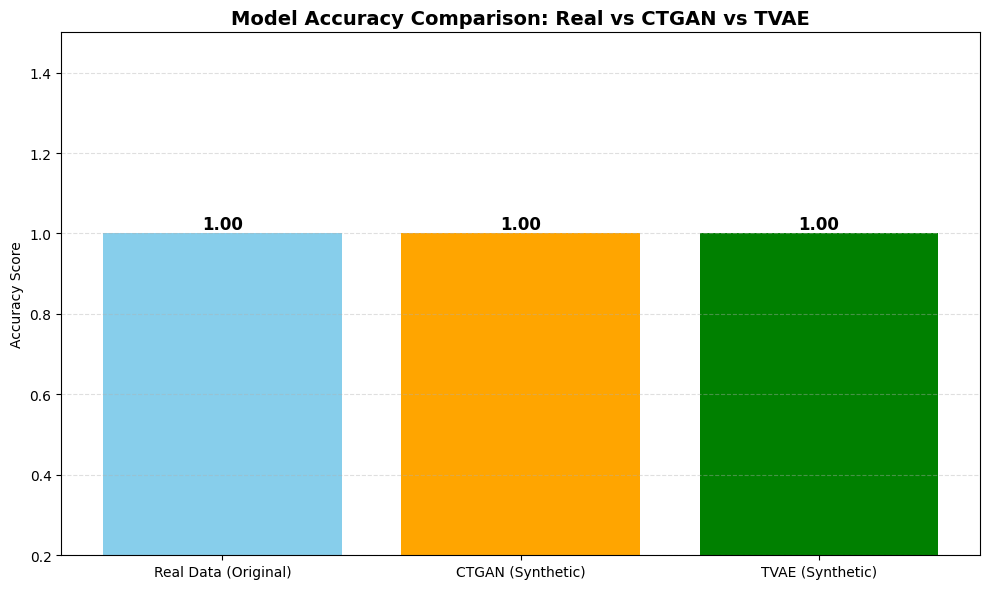

In [17]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
